In [101]:
# import numpy, matplotlib, and other things necessary for simulating a game of battleship
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm import tqdm

np.random.seed(298)

In [102]:
# define the ship size
ship_sizes = [(5, 1), (4, 1), (3, 1), (3, 1), (2, 1)]
num_ships = len(ship_sizes)
board_size = 10

# place ships on the board
def generate_board(board_size=board_size, num_ships=num_ships, ship_sizes=ship_sizes):
    board = np.zeros((board_size, board_size))
    for i in range(num_ships):
        ship_size = ship_sizes[i]
        if np.random.rand() > 0.5:
            ship_size = ship_size[::-1]
        ship = np.random.randint(0, board_size, 2) # Place ship

        # Check if ship would overlap with existing ships or be adjacent to them
        while (ship[0] + ship_size[0] > board_size or
            ship[1] + ship_size[1] > board_size or
            np.any(board[max(0, ship[0]-1):min(board_size, ship[0]+ship_size[0]+1),
                        max(0, ship[1]-1):min(board_size, ship[1]+ship_size[1]+1)] > 0)):

            ship = np.random.randint(0, board_size, 2) # Place ship

        board[ship[0]:ship[0]+ship_size[0], ship[1]:ship[1]+ship_size[1]] = 1 # Mark grid as occupied

    return board

board = generate_board(board_size, num_ships)

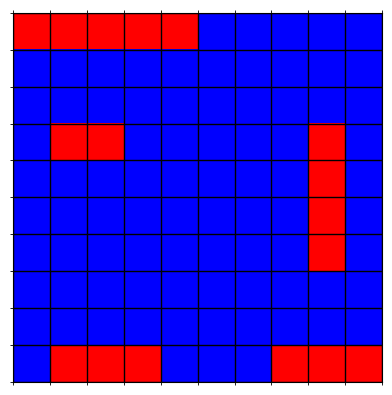

In [103]:
def generate_plot(board, board_size=board_size):
    # create figure and axis
    fig, ax = plt.subplots()

    # create a matrix plot of the board
    cmap = colors.ListedColormap(['blue', 'red'])
    ax.matshow(board, cmap=cmap)

    # put grid lines in plot
    ax.grid(True, which='both', color='black', linewidth=1)

    # Set the ticks to be at the center of each cell
    ax.set_xticks(np.arange(-.5, board_size, 1), minor=True)
    ax.set_yticks(np.arange(-.5, board_size, 1), minor=True)

    # Remove major tick labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Show the plot
    plt.show()

generate_plot(board)

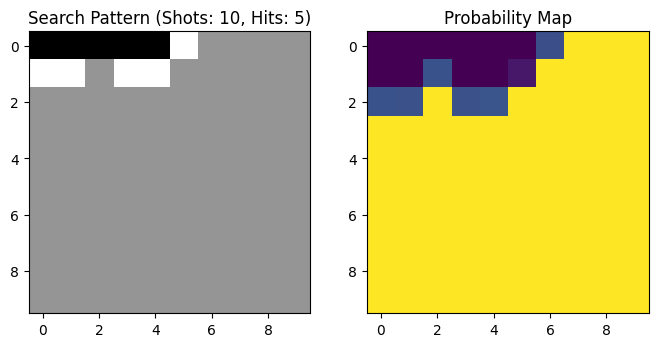

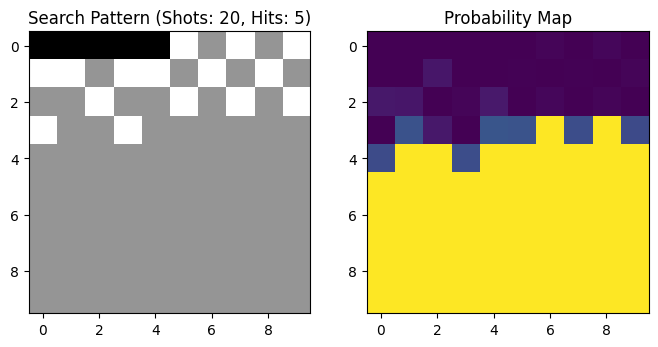

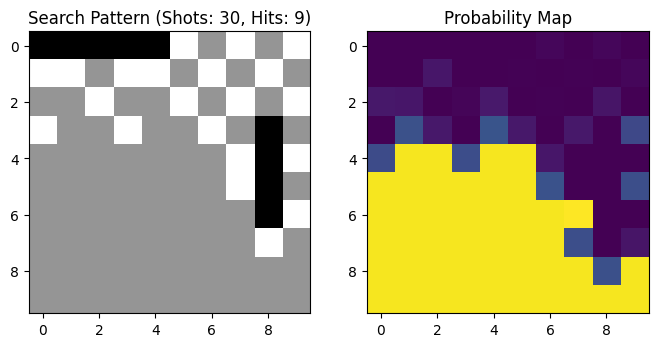

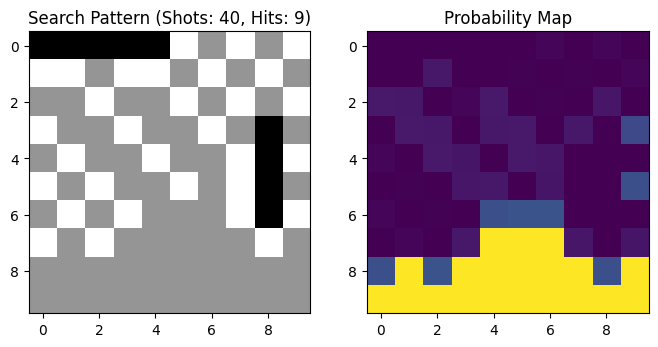

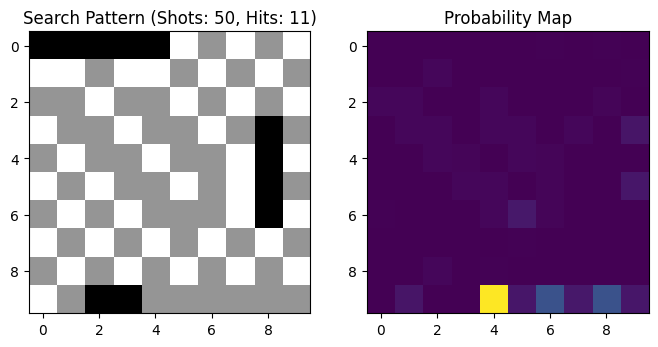

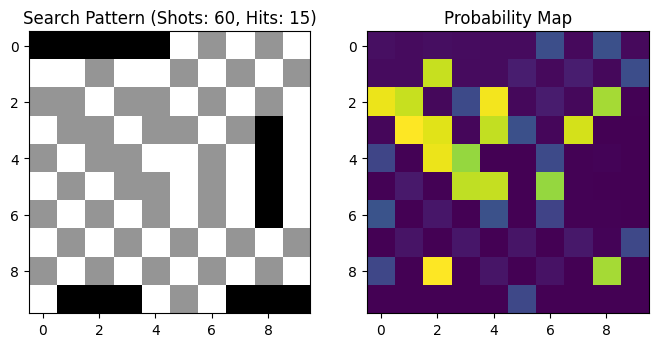

Found all ships in 63 shots


In [104]:
# Generate uniform prior
uniform_prob_map = np.ones((board_size, board_size)) / (board_size * board_size)

def bayesian_search(prob_map=uniform_prob_map, board=board, noise=0.01, visualize=True, board_size=board_size):
    # Initialize probability distribution (uniform prior)
    # prob_map = np.ones((board_size, board_size)) / (board_size * board_size)

    # Initialize hit map to track shots
    hit_map = np.zeros((board_size, board_size))

    # Prior knowledge: ships are more likely to be in lines
    def update_probabilities(prob_map, x, y, hit):
        # Update based on hit or miss
        if hit:
            # If hit, increase probability of adjacent cells
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size and hit_map[new_x, new_y] == 0:
                    prob_map[new_x, new_y] *= 4 + np.random.normal(0, noise)
        else:
            # If miss, decrease probability of adjacent cells
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size:
                    prob_map[new_x, new_y] *= 0.25 + np.random.normal(0, noise)

        # Normalize probabilities
        prob_map = prob_map / np.sum(prob_map) + 1e-6  # div by 0
        return prob_map

    # Simulate search
    shots = 0
    hits = 0
    while hits < np.sum(board):  # Continue until all ships are found
        # Find highest probability location
        x, y = np.unravel_index(np.argmax(prob_map), prob_map.shape)

        # Take shot
        hit = board[x, y] == 1
        hit_map[x, y] = 1 if hit else -1
        shots += 1

        if hit:
            hits += 1

        # Update probabilities
        prob_map[x, y] = 0  # Zero out probability of searched location
        prob_map = update_probabilities(prob_map, x, y, hit)

        # Visualize current state (optional)
        if visualize and shots % 10 == 0:  # Show every 10 shots
            plt.figure(figsize=(8, 4))

            plt.subplot(121)
            plt.imshow(hit_map, cmap='Greys')
            plt.title(f'Search Pattern (Shots: {shots}, Hits: {hits})')

            plt.subplot(122)
            plt.imshow(prob_map, cmap='viridis')
            plt.title('Probability Map')

            plt.show()

    return shots, hit_map

# Run the search on a uniform prior
shots, final_pattern = bayesian_search(uniform_prob_map)
print(f"Found all ships in {shots} shots")

In [105]:
# Generate 100 sample boards
def generate_n_sample_boards(n):
    return [generate_board() for _ in range(n)]

test_boards = generate_n_sample_boards(50)
print(f"Generated {len(test_boards)} sample boards")

# for board in test_boards[:3]:
#     generate_plot(board)

# Run the simulation on the test boards, return mean and variance of the number of shots
shot_history = []
for board in tqdm(test_boards):
    shots, final = bayesian_search(prob_map=uniform_prob_map, board=board, visualize=False)
    shot_history.append(shots)

mean_shots = np.mean(shot_history)
var_shots = np.var(shot_history)

print(f"Mean shots: {mean_shots}")
print(f"Variance of shots: {var_shots}")


Generated 50 sample boards


100%|██████████| 50/50 [00:00<00:00, 363.04it/s]

Mean shots: 78.08
Variance of shots: 67.9136


## Improved search

In [106]:
uniform_prob_map = np.ones((board_size, board_size)) / (board_size * board_size)

def bayesian_search_v2(prob_map=uniform_prob_map, board=board, visualize=False, board_size=board_size):
    # Initialize hit map to track shots
    hit_map = np.zeros((board_size, board_size))

    # Prior knowledge: ships are more likely to be in lines
    def update_probabilities(prob_map, x, y, hit):
        # Update based on hit or miss
        if hit:
            # If hit, increase probability of adjacent cells
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size and hit_map[new_x, new_y] == 0:
                    prob_map[new_x, new_y] = 1

            # Check for adjacent hits to determine ship orientation
            adjacent_hits = []
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                adj_x, adj_y = x + dx, y + dy
                if (0 <= adj_x < board_size and 0 <= adj_y < board_size and
                    hit_map[adj_x, adj_y] == 1):  # Found adjacent hit
                    adjacent_hits.append((dx, dy))

            # If we have adjacent hits, determine orientation and adjust probabilities
            if adjacent_hits:
                # Check if ship is horizontal (dx=0)
                if any(dx == 0 for dx, dy in adjacent_hits):
                    # Ship is horizontal, zero out vertical directions
                    for dx, dy in [(1,0), (-1,0)]:
                        adj_x, adj_y = x + dx, y + dy
                        if 0 <= adj_x < board_size and 0 <= adj_y < board_size and hit_map[adj_x, adj_y] == 0:
                            prob_map[adj_x, adj_y] = 0

                # Check if ship is vertical (dy=0)
                if any(dy == 0 for dx, dy in adjacent_hits):
                    # Ship is vertical, zero out horizontal directions
                    for dx, dy in [(0,1), (0,-1)]:
                        adj_x, adj_y = x + dx, y + dy
                        if 0 <= adj_x < board_size and 0 <= adj_y < board_size and hit_map[adj_x, adj_y] == 0:
                            prob_map[adj_x, adj_y] = 0
        else:
            # If miss, decrease probability of adjacent cells slightly
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size:
                    prob_map[new_x, new_y] *= 0.5

        # Normalize probabilities
        prob_map = prob_map / np.sum(prob_map) + 1e-9  # div by 0
        return prob_map

    # Simulate search
    shots = 0
    hits = 0
    while hits < np.sum(board):  # Continue until all ships are found
        # Find highest probability location
        x, y = np.unravel_index(np.argmax(prob_map), prob_map.shape)

        # Take shot
        hit = board[x, y] == 1
        hit_map[x, y] = 1 if hit else -1
        shots += 1

        if hit:
            hits += 1

        # Update probabilities
        prob_map[x, y] = 0  # Zero out probability of searched location
        prob_map = update_probabilities(prob_map, x, y, hit)

        # Visualize current state (optional)
        if visualize and shots % 10 == 0:  # Show every 10 shots
            plt.figure(figsize=(8, 4))

            plt.subplot(121)
            plt.imshow(hit_map, cmap='Greys')
            plt.title(f'Search Pattern (Shots: {shots}, Hits: {hits})')

            plt.subplot(122)
            plt.imshow(prob_map, cmap='viridis')
            plt.title('Probability Map')

            plt.show()

    return shots, hit_map

# Run the search on a uniform prior
shots, final_pattern = bayesian_search_v2(visualize=False)
print(f"Found all ships in {shots} shots")

Found all ships in 60 shots


In [107]:
# Generate 100 sample boards
def generate_n_sample_boards(n):
    return [generate_board() for _ in range(n)]

test_boards = generate_n_sample_boards(50)
print(f"Generated {len(test_boards)} sample boards")

# for board in test_boards[:3]:
#     generate_plot(board)

# Run the simulation on the test boards, return mean and variance of the number of shots
shot_history = []
for board in tqdm(test_boards):
    shots, final = bayesian_search_v2(prob_map=uniform_prob_map, board=board, visualize=False)
    shot_history.append(shots)

mean_shots = np.mean(shot_history)
var_shots = np.var(shot_history)

print(f"Mean shots: {mean_shots}")
print(f"Variance of shots: {var_shots}")


Generated 50 sample boards


100%|██████████| 50/50 [00:00<00:00, 578.20it/s]

Mean shots: 61.18
Variance of shots: 119.54760000000002


## Now we know if we sank a ship

In [108]:
from google.colab import files

In [ ]:
uniform_prob_map = np.ones((board_size, board_size)) / (board_size * board_size)

def bayesian_search_v3(prob_map=uniform_prob_map, board=board, visualize=False, board_size=board_size):
    # Initialize hit map to track shots
    hit_map = np.zeros((board_size, board_size))

    def get_ship_locations(board):
        ships = []
        visited = set()

        for i in range(board_size):
            for j in range(board_size):
                if board[i, j] == 1 and (i, j) not in visited:
                    # Found a new ship
                    ship = []
                    queue = [(i, j)]

                    while queue:
                        x, y = queue.pop(0)
                        if (x, y) in visited:
                            continue

                        visited.add((x, y))
                        if 0 <= x < board_size and 0 <= y < board_size and board[x, y] == 1:
                            ship.append((x, y))

                            # Add adjacent cells to the queue
                            for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                                nx, ny = x + dx, y + dy
                                if 0 <= nx < board_size and 0 <= ny < board_size and (nx, ny) not in visited and board[nx, ny] == 1:
                                    queue.append((nx, ny))

                    ships.append(ship)

        return ships

    def get_num_sunk(hit_map, board):
        ship_locations = get_ship_locations(board)
        ships_sunk = 0

        for ship in ship_locations:
            sunk = True
            for x, y in ship:
                if hit_map[x, y] != 1:  # If any part is not hit, ship is not sunk
                    sunk = False
                    break
            if sunk:
                ships_sunk += 1

        return ships_sunk

    # Prior knowledge: ships are more likely to be in lines
    def update_probabilities(prob_map, x, y, hit):
        # Setting all probabilities around sunk ships to zero
        if ship_just_sunk:
            # Get the locations of all ships
            ship_locations = get_ship_locations(board)
            sunk_ships = []

            # Identify which ships are sunk
            for ship in ship_locations:
                sunk = True
                for x, y in ship:
                    if hit_map[x, y] != 1:  # If any part is not hit, ship is not sunk
                        sunk = False
                        break
                if sunk:
                    sunk_ships.append(ship)

            # Set probabilities to 0 for all cells adjacent to sunk ships
            for ship in sunk_ships:
                for sx, sy in ship:
                    # Check all adjacent cells including diagonals
                    for dx in [-1, 0, 1]:
                        for dy in [-1, 0, 1]:
                            nx, ny = sx + dx, sy + dy
                            if 0 <= nx < board_size and 0 <= ny < board_size:
                                # Only set to zero if the cell is not part of the ship
                                if (nx, ny) not in ship:
                                    prob_map[nx, ny] = 0

        # Update based on hit or miss
        if hit:
            # If hit, increase probability of adjacent cells
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size and hit_map[new_x, new_y] == 0:
                    prob_map[new_x, new_y] = 1

            # Check for adjacent hits to determine ship orientation
            adjacent_hits = []
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                adj_x, adj_y = x + dx, y + dy
                if (0 <= adj_x < board_size and 0 <= adj_y < board_size and
                    hit_map[adj_x, adj_y] == 1):  # Found adjacent hit
                    adjacent_hits.append((dx, dy))

            # If we have adjacent hits, determine orientation and adjust probabilities
            if adjacent_hits:
                # Check if ship is horizontal (dx=0)
                if any(dx == 0 for dx, dy in adjacent_hits):
                    # Ship is horizontal, zero out vertical directions
                    for dx, dy in [(1,0), (-1,0)]:
                        adj_x, adj_y = x + dx, y + dy
                        if 0 <= adj_x < board_size and 0 <= adj_y < board_size and hit_map[adj_x, adj_y] == 0:
                            prob_map[adj_x, adj_y] = 0

                # Check if ship is vertical (dy=0)
                if any(dy == 0 for dx, dy in adjacent_hits):
                    # Ship is vertical, zero out horizontal directions
                    for dx, dy in [(0,1), (0,-1)]:
                        adj_x, adj_y = x + dx, y + dy
                        if 0 <= adj_x < board_size and 0 <= adj_y < board_size and hit_map[adj_x, adj_y] == 0:
                            prob_map[adj_x, adj_y] = 0
        else:
            # If miss, decrease probability of adjacent cells slightly
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size:
                    prob_map[new_x, new_y] *= 0.5

        # Normalize probabilities
        prob_map = prob_map / np.sum(prob_map) + 1e-9  # div by 0
        return prob_map


    # Simulate search
    shots = 0
    hits = 0
    num_ships_sunk = 0
    while hits < np.sum(board):  # Continue until all ships are found
        ship_just_sunk = False

        # Find highest probability location
        x, y = np.unravel_index(np.argmax(prob_map), prob_map.shape)

        # Take shot
        hit = board[x, y] == 1
        hit_map[x, y] = 1 if hit else -1
        shots += 1

        if hit:
            hits += 1
            # Update number of ships sunk
            curr_sunk = get_num_sunk(hit_map, board)
            if curr_sunk > num_ships_sunk:
                num_ships_sunk = curr_sunk
                ship_just_sunk = True

        # Update probabilities
        prob_map[x, y] = 0  # Zero out probability of searched location
        prob_map = update_probabilities(prob_map, x, y, hit)

        # Visualize current state (optional)
        if visualize and shots % 10 == 0:  # Show every 10 shots
        # if visualize and hit:
            plt.figure(figsize=(8, 4))

            plt.subplot(121)
            plt.imshow(hit_map, cmap='Greys')
            plt.title(f'Search Pattern (Shots: {shots}, Hits: {hits})')

            plt.subplot(122)
            plt.imshow(prob_map, cmap='viridis')
            plt.title('Probability Map')

            plt.show()
            # plt.savefig(f'visualization_{shots}.png')
            # files.download(f'visualization_{shots}.png')
            # plt.close()

    return shots, hit_map

# Run the search on a uniform prior
# generate_plot(board)
shots, final_pattern = bayesian_search_v3(visualize=False)
print(f"Found all ships in {shots} shots")

Found all ships in 53 shots


In [110]:
# Generate 100 sample boards
def generate_n_sample_boards(n):
    return [generate_board() for _ in range(n)]

test_boards = generate_n_sample_boards(50)
print(f"Generated {len(test_boards)} sample boards")

# for board in test_boards[:3]:
#     generate_plot(board)

# Run the simulation on the test boards, return mean and variance of the number of shots
shot_history = []
for board in tqdm(test_boards):
    shots, final = bayesian_search_v3(prob_map=uniform_prob_map, board=board, visualize=False)
    shot_history.append(shots)

mean_shots = np.mean(shot_history)
var_shots = np.var(shot_history)

print(f"Mean shots: {mean_shots}")
print(f"Variance of shots: {var_shots}")


Generated 50 sample boards


100%|██████████| 50/50 [00:00<00:00, 228.00it/s]

Mean shots: 53.52
Variance of shots: 60.3696


In [111]:
# Run the search on a edge-biased prior (Gaussian)
edge_bias_prob_map = np.ones((board_size, board_size))
edge_bias = np.zeros((board_size, board_size))

for i in range(board_size):
    for j in range(board_size):
        edge_bias[i, j] = np.exp(-((i - board_size/2)**2 + (j - board_size/2)**2) / (board_size/2)**2)
        edge_bias[i, j] = 1 - edge_bias[i, j]
edge_bias_prob_map = edge_bias / np.sum(edge_bias)

# Generate 100 sample boards
def generate_n_sample_boards(n):
    return [generate_board() for _ in range(n)]

test_boards = generate_n_sample_boards(50)
print(f"Generated {len(test_boards)} sample boards")

# for board in test_boards[:3]:
#     generate_plot(board)

# Run the simulation on the test boards, return mean and variance of the number of shots
shot_history = []
for board in tqdm(test_boards):
    shots, final = bayesian_search_v3(prob_map=edge_bias_prob_map, board=board, visualize=False)
    shot_history.append(shots)

mean_shots = np.mean(shot_history)
var_shots = np.var(shot_history)

print(f"Mean shots: {mean_shots}")
print(f"Variance of shots: {var_shots}")


Generated 50 sample boards


100%|██████████| 50/50 [00:00<00:00, 288.60it/s]

Mean shots: 51.82
Variance of shots: 94.0676


Generated 50 sample boards


100%|██████████| 50/50 [00:00<00:00, 236.04it/s]


Mean shots: 51.58
Variance of shots: 76.00359999999999


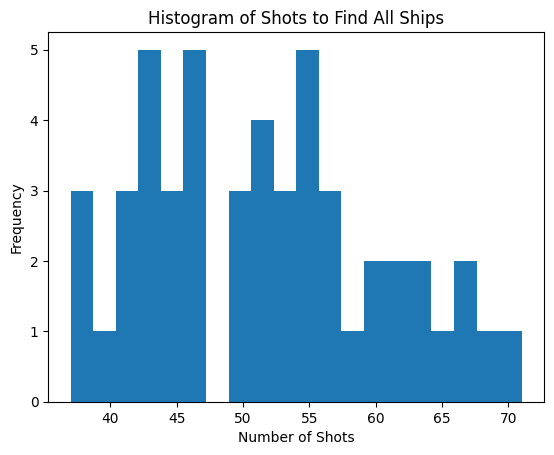

In [112]:
# Run the search on a center-biased prior (Gaussian)
center_bias_prob_map = np.ones((board_size, board_size))
center_bias = np.zeros((board_size, board_size))

for i in range(board_size):
    for j in range(board_size):
        center_bias[i, j] = np.exp(-((i - board_size/2)**2 + (j - board_size/2)**2) / (board_size/2)**2)
center_bias_prob_map = center_bias / np.sum(center_bias)

# Generate 100 sample boards
def generate_n_sample_boards(n):
    return [generate_board() for _ in range(n)]

test_boards = generate_n_sample_boards(50)
print(f"Generated {len(test_boards)} sample boards")

# for board in test_boards[:3]:
#     generate_plot(board)

# Run the simulation on the test boards, return mean and variance of the number of shots
shot_history = []
for board in tqdm(test_boards):
    shots, final = bayesian_search_v3(prob_map=center_bias_prob_map, board=board, visualize=False)
    shot_history.append(shots)

mean_shots = np.mean(shot_history)
var_shots = np.var(shot_history)

print(f"Mean shots: {mean_shots}")
print(f"Variance of shots: {var_shots}")

# Show histogram of shots
plt.hist(shot_history, bins=20)
plt.xlabel('Number of Shots')
plt.ylabel('Frequency')
plt.title('Histogram of Shots to Find All Ships')
plt.show()

In [113]:
# For animation
shots, final = bayesian_search_v3(prob_map=center_bias_prob_map, board=board, visualize=False)